In [10]:
import pandas as pd
import numpy as np
import re
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from textattack import Attacker, AttackArgs
from textattack.datasets import Dataset
from textattack.models.wrappers import ModelWrapper
from textattack.attack_recipes import TextFoolerJin2019, DeepWordBugGao2018
import textattack
import tensorflow

In [34]:
# Charger le jeu de données
try:
    df = pd.read_csv("../data/training.1600000.processed.noemoticon.csv", encoding="latin-1")
    df = df.iloc[:, [0, 5]]  # Garder sentiment (colonne 0) et texte (colonne 5)
    df.columns = ['sentiment', 'text']
    df['sentiment'] = df['sentiment'].map({0: 'negatif', 4: 'positif'})
    df.drop_duplicates(inplace=True)
except FileNotFoundError:
    print("Erreur : Le fichier '../data/training.1600000.processed.noemoticon.csv' n'existe pas.")
    print("Veuillez vérifier le chemin ou placez le fichier dans le dossier 'data'.")
    exit()

In [35]:
# Fonction de nettoyage des textes
def clean_text(text):
    text = str(text)  # S'assurer que l'entrée est une chaîne
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)  # Supprimer URLs, mentions, hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer caractères spéciaux
    text = text.strip().lower()
    # Supprimer les textes trop courts (moins de 3 mots)
    if len(text.split()) < 3:
        return ''
    return text

In [36]:
# Appliquer le nettoyage
df['text'] = df['text'].apply(clean_text)
df = df[df['text'] != '']  # Supprimer les textes vides ou trop courts
df = df.dropna(subset=['text', 'sentiment'])  # Supprimer les lignes avec NaN

In [33]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  # ex: 

In [38]:
mapping = {'negatif': 0, 'positif': 1}
df['label_encoded'] = df['sentiment'].map(mapping)
print(df[['sentiment', 'label_encoded']].head())

df.head()

  sentiment  label_encoded
0   negatif              0
1   negatif              0
2   negatif              0
3   negatif              0
4   negatif              0


,sentiment,text,label_encoded
0,negatif,is upset that he cant update his facebook by t...,0
1,negatif,i dived many times for the ball managed to sav...,0
2,negatif,my whole body feels itchy and like its on fire,0
3,negatif,no its not behaving at all im mad why am i her...,0
4,negatif,not the whole crew,0


In [ ]:
df_tuning = pd.read_excel("data_with_adversarial_examples.xlsx")
df_tuning['text'] = df_tuning['text'].apply(clean_text)
df_tuning = df_tuning[df_tuning['text'] != '']  # Supprimer les textes vides ou trop courts
df_tuning = df_tuning.dropna(subset=['text', 'sentiment'])  # Supprimer les lignes avec NaN



In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encoder les labels (ex: positive, negative)
le = LabelEncoder()
df_tuning['label'] = le.fit_transform(df_tuning['sentiment'])

texts = df_tuning['text'].tolist()
labels = df_tuning['label'].values

# Convertir les textes en séquences avec le tokenizer chargé
sequences = tokenizer.texts_to_sequences(texts)

# Padding des séquences pour avoir la même longueur (128 ici, à adapter)
max_len = 128
X = pad_sequences(sequences, maxlen=max_len, padding='post')

y = labels


In [17]:
model= load_model("../models/best_model.keras")

In [18]:
import pickle

with open("../models/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [45]:
df_tuning.head(10)

,sentiment,text,label
0,1,redoinq the myspace,1
1,1,listening to lines vines amp trying times its...,1
2,0,buxie wid mah assignment,0
3,0,i want and need him to be the father of my bab...,0
4,0,why you dont reply to me i give up i try try ...,0
5,0,oh no craaaaazy mary keenan just got knocked ...,0
6,1,well there are some of us out there,1
8,1,girl that reminds me of one of my fav songs ex...,1
9,1,good morning ah whatam i going to do today mi...,1
10,1,ive still got simon at my apartment reminds me...,1


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# --- 1. Charger le fichier Excel ---
df = pd.read_excel("data_with_adversarial_examples.xlsx")

# --- 2. Nettoyer les données (facultatif selon ton cas) ---
# Par exemple ici, on enlève les lignes vides dans 'text'
df = df[df['text'].notna()]
df = df[df['text'].str.strip() != '']

# --- 3. Préparer les données ---
texts = df['text'].tolist()
labels = df['sentiment'].values  # déjà 0/1, parfait

# --- 4. Tokenizer + padding ---
max_vocab_size = 10000
max_seq_length = 100  # à adapter selon ton modèle

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=max_seq_length, padding='post', truncating='post')

y = labels

print(f"Shape X: {X.shape}")  # (nb_samples, max_seq_length)
print(f"Shape y: {y.shape}")  # (nb_samples,)

# --- 5. Charger le modèle pré-entraîné ---
model = load_model("../models/best_model.keras")

# --- 6. Compiler le modèle pour fine-tuning ---
model.compile(optimizer=Adam(learning_rate=3e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 7. Early stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X, y,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Shape X: (108996, 100)
Shape y: (108996,)
Epoch 1/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 96s 30ms/step - accuracy: 0.4978 - loss: 0.7948 - val_accuracy: 0.4550 - val_loss: 0.7237
Epoch 2/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 89s 29ms/step - accuracy: 0.5274 - loss: 0.6946 - val_accuracy: 0.4703 - val_loss: 0.7048
Epoch 3/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 342s 112ms/step - accuracy: 0.5651 - loss: 0.6804 - val_accuracy: 0.5383 - val_loss: 0.6896
Epoch 4/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 91s 30ms/step - accuracy: 0.5978 - loss: 0.6647 - val_accuracy: 0.5629 - val_loss: 0.6842
Epoch 5/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 94s 31ms/step - accuracy: 0.6222 - loss: 0.6482 - val_accuracy: 0.5968 - val_loss: 0.6684
Epoch 6/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - accuracy: 0.6430 - loss: 0.6329 - val_accuracy: 0.5962 - val_loss: 0.6736
Epoch 7/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.6631 - loss: 0.6157 - val_accuracy: 0.6066 - val_loss: 0.6689
Epoch 8/100
3066/3066 ━━━

3407/3407 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


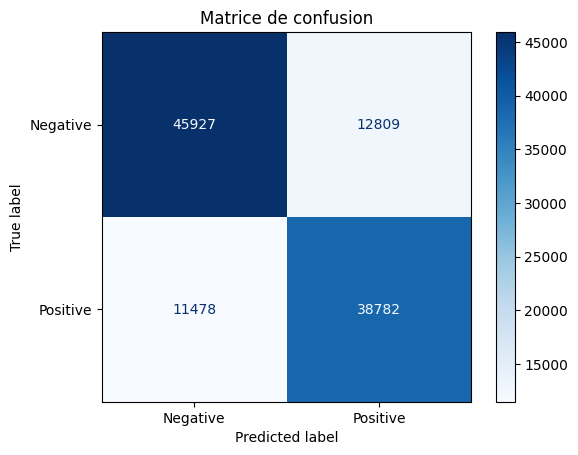

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Prédictions sur les données de validation ---
y_pred_probs = model.predict(X)
y_pred = np.argmax(y_pred_probs, axis=1)  # classes prédites
y_true = y  # vraies étiquettes

# --- 2. Matrice de confusion ---
cm = confusion_matrix(y_true, y_pred)

# --- 3. Affichage ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


In [50]:
model.save("fine_tuned_model.keras")
print("✅ Modèle fine-tuné sauvegardé sous 'fine_tuned_model.keras'")

✅ Modèle fine-tuné sauvegardé sous 'fine_tuned_model.keras'


In [52]:
# ... (le même début de script jusqu'à la définition du wrapper) ...

# --- 4. Définir l'attaque PWWS ---
from textattack.attack_recipes import PWWSRen2019
attack = PWWSRen2019.build(wrapper)

# --- 5. Tester sur plusieurs phrases ---
num_tests = 100  # Tu peux ajuster ce nombre (ex: len(df) pour tout attaquer)
test_samples = df.sample(n=num_tests, random_state=42)[['text', 'sentiment']]

n_success = 0
n_failed = 0

print("\n=== 🔥 Lancement des attaques adversariales (PWWS) ===\n")

for idx, row in test_samples.iterrows():
    original_text = row['text']
    true_label = int(row['sentiment'])

    try:
        result = attack.attack(original_text, ground_truth_output=true_label)
        if isinstance(result, textattack.attack_results.SuccessfulAttackResult):
            n_success += 1
            print(f"✅ Succès [{idx}] : {result.perturbed_text()}")
        else:
            n_failed += 1
            print(f"🛡️ Échec [{idx}] : Pas de perturbation.")
    except Exception as e:
        n_failed += 1
        print(f"❌ Erreur [{idx}] : {e}")

# --- 6. Résumé ---
print("\n=== 📊 Résumé de l'attaque ===")
print(f"Total exemples testés : {num_tests}")
print(f"✅ Attaques réussies    : {n_success}")
print(f"🛡️ Attaques échouées    : {n_failed}")
print(f"🔁 Taux de réussite      : {100 * n_success / num_tests:.2f}%")


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
textattack: Unknown if model of class <class 'keras.src.models.sequential.Sequential'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.



=== 🔥 Lancement des attaques adversariales (PWWS) ===

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Succès [28161] : @AnnaAntell oh nooooo, miserable you  hate idiot thieves who have to ruin everything... hope you sort it out go x
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Succès [73672] : the connection i glue 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🛡️ Échec [89420] : Pas de perturbation.
1/1 ━━━